# <center>Word Embedding</center>




***
## <font color = blue>I. DATA PREPARATION</font>
> A. LIBRARIES<br>
> B. COLLECTING DATA AND CREATING DICTIONARIES<br>
> C. DATA CLEANING AND DROP NaN<br>
> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>
> F. TOKENIZE TRAINING SET AND TEST SET <br>

## <font color = blue>II. MODEL WORD EMBEDDING</font>
> A. CREATION OF MODEL<br>
> B. COMPILING AND TRAINING<br>
> C. TRAINING HISTORY<br>
> D. CONFUSION MATRIX<br>
> E. CLASSIFICATION REPORT<br>

## <font color = blue>I. DATA PREPARATION</font>

> A. LIBRARIES<br>

In [46]:
import pandas as pd
import re
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.metrics import classification_report

> B. COLLECTING DATA AND CREATING DICTIONARIES<br>

In [47]:

df = pd.read_csv('data.csv')
df.head()


,Unnamed: 0.1,Unnamed: 0,filename,url,description,type,filepath,scraped,old_filename,old_filepath,...,text_ocr,words_count,text_en,text_fr,text_fr_norm,text_en_norm,target_en,target_fr,target,target_min
0,0,0,img_0000000.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000000.jpg,1,img_0000000.jpg,./facture/img_0000000.jpg,...,FACTURE LOGO Joanna Binet 48 Coubertin 31400 ...,98,Invoice Logo Joanna Binet Coubertin Paris Invo...,Facture Logo Joanna Binet Coubertin Paris F...,facture logo joanna binet coubertin paris fact...,invoice logo joanna binet coubertin paris invo...,invoice,facture,invoice,invoice
1,1,1,img_0000001.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000001.jpg,1,img_0000001.jpg,./facture/img_0000001.jpg,...,Joanna Binet 48 Coubertin 31400 Paris FACTURE...,97,Joanna Binet Coubertin Paris Invoice Invoice i...,Joanna Binet Coubertin Paris Facture Factur...,joanna binet coubertin paris facture facturé c...,joanna binet coubertin paris invoice invoice c...,invoice,facture,invoice,invoice
2,2,2,img_0000002.jpg,https://www.coover.fr/wp-content/uploads/2021/...,Facture proforma : modèle à télécharger gratui...,facture,./final/img_0000002.jpg,1,img_0000002.jpg,./facture/img_0000002.jpg,...,FACTURE Mon entreprise : Nom de la société Ad...,45,Invoice My company : Company name Mail address...,Facture Mon entreprise : Nom de la société Ad...,facture entreprise société adresse postale adr...,invoice company company name mail address tele...,invoice,facture,invoice,invoice
3,3,3,img_0000003.jpg,https://templates.invoicehome.com/modele-factu...,100 modèles gratuits de factures | Téléchargem...,facture,./final/img_0000003.jpg,1,img_0000003.jpg,./facture/img_0000003.jpg,...,Joanna Binet 48 Coubertin 31400 Paris FACTURE...,99,Joanna Binet Coubertin Paris Bill To Cinderell...,Joanna Binet Coubertin Paris Facture À Cend...,joanna binet coubertin paris facture cendrillo...,joanna binet coubertin paris bill cinderella a...,invoice,facture,invoice,invoice
4,4,4,img_0000004.jpg,https://files.intum.com/v/vosfactures/files/31...,Base de Connaissances - Vos Factures - Créer u...,facture,./final/img_0000004.jpg,1,img_0000004.jpg,./facture/img_0000004.jpg,...,Payer en ligne > FACTURE No SFIDELI F/05.2020...,157,Pay online Invoice No Sfideli F/ Creation date...,Payer en ligne Facture No Sfideli F/ Date de...,payer ligne facture sfideli date création date...,online invoice sfideli creation date validity ...,invoice,facture,invoice,invoice


In order to improve the performance, we will group some classes 

In [48]:
# Replace current classes by new classes i.e by grouping certain classes together

new_classes =  { 'advertisement': 'other_types',
                'form'        : 'other_types',
               'handwritten' : 'other_types',
               'letter' : 'other_types',
                'memo': 'other_types',
                'presentation': 'other_types',
               'invoice' :'facture',
               'news_article': 'scientific_doc',
               'scientific_publication': 'scientific_doc',
               'scientific_report': 'scientific_doc'}

df = df.replace(new_classes)


In [49]:
# Creating dictionary
dico_type = {'facture': 0,
             'id_pieces': 1,
             'justif_domicile': 2,
             'passeport': 3,
             'paye': 4,
             'carte postale': 5,
             'other_types': 6,
             'scientific_doc': 7,
             'resume': 8,
             'specification': 9,
             'budget': 10,
             'file_folder': 11,
             'email': 12,
             'questionnaire': 13}

# Creating revert dictionary
dico_type_inv = {v: k for k, v in dico_type.items()}

# Convert types according to the dictionary
df['type_num'] = df.type.replace(dico_type)

> C. DATA CLEANING AND DROP NaN<br>

In [50]:


stop_words = {'en' : set(stopwords.words('english')),
              'fr':set(stopwords.words('french')),
              'it':set(stopwords.words('italian')),
              'de':set(stopwords.words('german')),
              'nl':set(stopwords.words('dutch')),
              'es':set(stopwords.words('spanish')),
              'pt':set(stopwords.words('portuguese'))
             }


# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(str(w).lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()
    
df['ntext']  = df.text_ocr.apply(lambda x :preprocess_sentence(x))

df = df.dropna(subset = ['ntext']) # DROP NaN
df['ntext'].head(20)



0     facture logo joanna binet coubertin paris fact...
1     joanna binet coubertin paris facture facture c...
2     facture mon entreprise nom societe adresse pos...
3     joanna binet coubertin paris facture cendrillo...
4     payer ligne facture sfideli . date creation da...
5     joanna binet coubertin paris facture cendrillo...
6     nom entreprise facture adresse ville province ...
7     ivotre societe choisir une dato facture factur...
8     identification vendeur nom independant adresse...
9     facture joanna binet coubertin paris facture c...
10    facture date facauraton puiputt etheance renov...
11    facture nom votre societe adresse ville siret ...
12    invoice brand name invoice dwyane clark . dumm...
13    nom compagnie details contact logo adresse pos...
14    nom votre entreprise siogan votre entreprise a...
15    logo date numero facture nom entreprise adress...
16    facture nom entreprise nom entreprise . com ru...
17    votre contrat electricite tarif bleu kva o

> D. SPLIT BETWEEN TRAINING SET AND TEST SET<br>


In [51]:

encoder =  LabelEncoder()

Y = encoder.fit_transform(df['type'])

X_text_train, X_text_test, y_train, y_test = train_test_split(df['ntext'], Y, test_size=0.2, random_state=1234)


> F. TOKENIZE TRAINING SET AND TEST SET <br>

The Tokenizer class of tensorflow.keras.preprocessing.text makes it possible to vectorize a corpus of text, by transforming each text into a sequence of integers (each integer being the index of a token in a dictionary).

In [52]:

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_text_train) # fit the tokenizer

X_train = tokenizer.texts_to_sequences(X_text_train)
X_test = tokenizer.texts_to_sequences(X_text_test)

In [53]:
#Turn X_train sequence list into numpy array
X_train = pad_sequences(X_train, maxlen=500, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=500, padding='post', truncating='post')



## <font color = blue>II. MODEL WORD EMBEDDING</font>
> A. CREATION OF MODEL<br>


In [54]:


embedding_dim = 200
model = Sequential()
model.add(Embedding(10000, embedding_dim))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(14, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         2000000   
                                                                 
 global_average_pooling1d_3   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               51456     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 14)                3598      
                                                                 
Total params: 2,055,054
Trainable params: 2,055,054
Non-trainable params: 0
____________________________________________

> B. COMPILING AND TRAINING<br>

In [55]:
opt = tf.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,            # Training dataset
                    batch_size = 400,            # Number of samples per gradient update
                    epochs = 400,                # Number of epoch
                    validation_split = 0.2)      # validation data

Epoch 1/400
3/3 [==============================] - 1s 200ms/step - loss: 2.6282 - accuracy: 0.1675 - val_loss: 2.5977 - val_accuracy: 0.1952
Epoch 2/400
3/3 [==============================] - 0s 107ms/step - loss: 2.5922 - accuracy: 0.1986 - val_loss: 2.5627 - val_accuracy: 0.2571
Epoch 3/400
3/3 [==============================] - 0s 107ms/step - loss: 2.5578 - accuracy: 0.2225 - val_loss: 2.5250 - val_accuracy: 0.2381
Epoch 4/400
3/3 [==============================] - 0s 103ms/step - loss: 2.5192 - accuracy: 0.1926 - val_loss: 2.4817 - val_accuracy: 0.2381
Epoch 5/400
3/3 [==============================] - 0s 104ms/step - loss: 2.4768 - accuracy: 0.2033 - val_loss: 2.4344 - val_accuracy: 0.2476
Epoch 6/400
3/3 [==============================] - 0s 106ms/step - loss: 2.4308 - accuracy: 0.2225 - val_loss: 2.3868 - val_accuracy: 0.2048
Epoch 7/400
3/3 [==============================] - 0s 105ms/step - loss: 2.3885 - accuracy: 0.2069 - val_loss: 2.3445 - val_accuracy: 0.2000
Epoch 8/400
3

Epoch 59/400
3/3 [==============================] - 0s 102ms/step - loss: 1.6282 - accuracy: 0.4593 - val_loss: 1.6786 - val_accuracy: 0.4333
Epoch 60/400
3/3 [==============================] - 0s 101ms/step - loss: 1.5993 - accuracy: 0.4701 - val_loss: 1.6643 - val_accuracy: 0.4381
Epoch 61/400
3/3 [==============================] - 0s 103ms/step - loss: 1.5916 - accuracy: 0.5048 - val_loss: 1.6556 - val_accuracy: 0.4524
Epoch 62/400
3/3 [==============================] - 0s 103ms/step - loss: 1.5727 - accuracy: 0.5156 - val_loss: 1.6389 - val_accuracy: 0.4476
Epoch 63/400
3/3 [==============================] - 0s 102ms/step - loss: 1.5546 - accuracy: 0.5144 - val_loss: 1.6356 - val_accuracy: 0.4429
Epoch 64/400
3/3 [==============================] - 0s 102ms/step - loss: 1.5383 - accuracy: 0.5191 - val_loss: 1.6341 - val_accuracy: 0.4429
Epoch 65/400
3/3 [==============================] - 0s 103ms/step - loss: 1.5279 - accuracy: 0.5096 - val_loss: 1.6200 - val_accuracy: 0.4524
Epoch 

3/3 [==============================] - 0s 102ms/step - loss: 0.9842 - accuracy: 0.7165 - val_loss: 1.3181 - val_accuracy: 0.5667
Epoch 117/400
3/3 [==============================] - 0s 102ms/step - loss: 0.9790 - accuracy: 0.7141 - val_loss: 1.2860 - val_accuracy: 0.5667
Epoch 118/400
3/3 [==============================] - 0s 103ms/step - loss: 0.9738 - accuracy: 0.7225 - val_loss: 1.2837 - val_accuracy: 0.5619
Epoch 119/400
3/3 [==============================] - 0s 109ms/step - loss: 0.9723 - accuracy: 0.7189 - val_loss: 1.2941 - val_accuracy: 0.5619
Epoch 120/400
3/3 [==============================] - 0s 108ms/step - loss: 0.9467 - accuracy: 0.7356 - val_loss: 1.2823 - val_accuracy: 0.5667
Epoch 121/400
3/3 [==============================] - 0s 109ms/step - loss: 0.9480 - accuracy: 0.7237 - val_loss: 1.2748 - val_accuracy: 0.5762
Epoch 122/400
3/3 [==============================] - 0s 104ms/step - loss: 0.9472 - accuracy: 0.7261 - val_loss: 1.2684 - val_accuracy: 0.5762
Epoch 123/400

3/3 [==============================] - 0s 109ms/step - loss: 0.7111 - accuracy: 0.7990 - val_loss: 1.1758 - val_accuracy: 0.5952
Epoch 174/400
3/3 [==============================] - 0s 108ms/step - loss: 0.6990 - accuracy: 0.8026 - val_loss: 1.1644 - val_accuracy: 0.6095
Epoch 175/400
3/3 [==============================] - 0s 108ms/step - loss: 0.7053 - accuracy: 0.8050 - val_loss: 1.1584 - val_accuracy: 0.6286
Epoch 176/400
3/3 [==============================] - 0s 106ms/step - loss: 0.6805 - accuracy: 0.8134 - val_loss: 1.1620 - val_accuracy: 0.6238
Epoch 177/400
3/3 [==============================] - 0s 104ms/step - loss: 0.6938 - accuracy: 0.8002 - val_loss: 1.1801 - val_accuracy: 0.6000
Epoch 178/400
3/3 [==============================] - 0s 102ms/step - loss: 0.6912 - accuracy: 0.7871 - val_loss: 1.2026 - val_accuracy: 0.5810
Epoch 179/400
3/3 [==============================] - 0s 101ms/step - loss: 0.7153 - accuracy: 0.7763 - val_loss: 1.1903 - val_accuracy: 0.5905
Epoch 180/400

3/3 [==============================] - 0s 111ms/step - loss: 0.5643 - accuracy: 0.8409 - val_loss: 1.1386 - val_accuracy: 0.6286
Epoch 231/400
3/3 [==============================] - 0s 115ms/step - loss: 0.5555 - accuracy: 0.8325 - val_loss: 1.1421 - val_accuracy: 0.6143
Epoch 232/400
3/3 [==============================] - 0s 106ms/step - loss: 0.5598 - accuracy: 0.8289 - val_loss: 1.1313 - val_accuracy: 0.6429
Epoch 233/400
3/3 [==============================] - 0s 103ms/step - loss: 0.5708 - accuracy: 0.8337 - val_loss: 1.1411 - val_accuracy: 0.6524
Epoch 234/400
3/3 [==============================] - 0s 105ms/step - loss: 0.5674 - accuracy: 0.8433 - val_loss: 1.1385 - val_accuracy: 0.6333
Epoch 235/400
3/3 [==============================] - 0s 106ms/step - loss: 0.5496 - accuracy: 0.8421 - val_loss: 1.1377 - val_accuracy: 0.6190
Epoch 236/400
3/3 [==============================] - 0s 104ms/step - loss: 0.5524 - accuracy: 0.8313 - val_loss: 1.1501 - val_accuracy: 0.6190
Epoch 237/400

3/3 [==============================] - 0s 104ms/step - loss: 0.4840 - accuracy: 0.8577 - val_loss: 1.1651 - val_accuracy: 0.6333
Epoch 288/400
3/3 [==============================] - 0s 112ms/step - loss: 0.4804 - accuracy: 0.8541 - val_loss: 1.1786 - val_accuracy: 0.6143
Epoch 289/400
3/3 [==============================] - 0s 105ms/step - loss: 0.4974 - accuracy: 0.8457 - val_loss: 1.1494 - val_accuracy: 0.6524
Epoch 290/400
3/3 [==============================] - 0s 120ms/step - loss: 0.4758 - accuracy: 0.8624 - val_loss: 1.1794 - val_accuracy: 0.6619
Epoch 291/400
3/3 [==============================] - 0s 103ms/step - loss: 0.4958 - accuracy: 0.8565 - val_loss: 1.1613 - val_accuracy: 0.6571
Epoch 292/400
3/3 [==============================] - 0s 104ms/step - loss: 0.4804 - accuracy: 0.8589 - val_loss: 1.1819 - val_accuracy: 0.6095
Epoch 293/400
3/3 [==============================] - 0s 102ms/step - loss: 0.5082 - accuracy: 0.8493 - val_loss: 1.1643 - val_accuracy: 0.6333
Epoch 294/400

3/3 [==============================] - 0s 108ms/step - loss: 0.4382 - accuracy: 0.8636 - val_loss: 1.1927 - val_accuracy: 0.6667
Epoch 345/400
3/3 [==============================] - 0s 112ms/step - loss: 0.4434 - accuracy: 0.8696 - val_loss: 1.1886 - val_accuracy: 0.6619
Epoch 346/400
3/3 [==============================] - 0s 113ms/step - loss: 0.4351 - accuracy: 0.8744 - val_loss: 1.1949 - val_accuracy: 0.6571
Epoch 347/400
3/3 [==============================] - 0s 110ms/step - loss: 0.4431 - accuracy: 0.8660 - val_loss: 1.1870 - val_accuracy: 0.6524
Epoch 348/400
3/3 [==============================] - 0s 108ms/step - loss: 0.4333 - accuracy: 0.8684 - val_loss: 1.1885 - val_accuracy: 0.6810
Epoch 349/400
3/3 [==============================] - 0s 110ms/step - loss: 0.4516 - accuracy: 0.8648 - val_loss: 1.2302 - val_accuracy: 0.6286
Epoch 350/400
3/3 [==============================] - 0s 107ms/step - loss: 0.4431 - accuracy: 0.8672 - val_loss: 1.1801 - val_accuracy: 0.6714
Epoch 351/400

> C. TRAINING HISTORY<br>


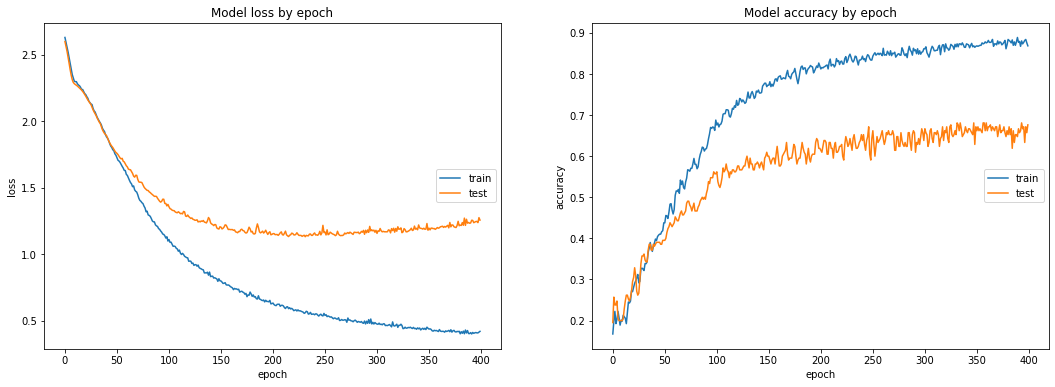

In [58]:
plt.figure(figsize=(18,6))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

> D. CONFUSION MATRIX<br>

In [59]:
####### PREDICTIONS #######

y_prob = model.predict(X_test)

# Class predictions
y_pred = y_prob.argmax(axis=1)


9/9 [==============================] - 0s 5ms/step


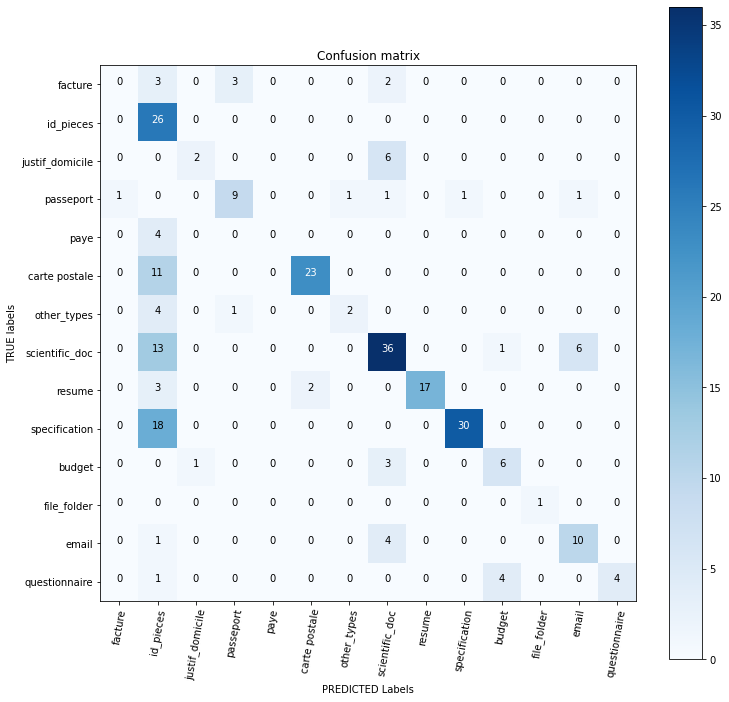

In [60]:
cnf_matrix = confusion_matrix(y_test, y_pred)

classes = dico_type
plt.figure(figsize = (12, 12))

plt.imshow(cnf_matrix, interpolation = 'nearest', cmap = 'Blues')
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation = 80)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('TRUE labels')
plt.xlabel('PREDICTED Labels')
plt.show()

> E. CLASSIFICATION REPORT<br>

In [61]:
target = df['type'].unique().tolist()
target_test = [target[i] for i in y_test]
target_pred = [target[i] for i in y_pred]

print( classification_report(target_test, target_pred) )


                 precision    recall  f1-score   support

         budget       0.55      0.60      0.57        10
  carte postale       0.92      0.68      0.78        34
          email       0.59      0.67      0.62        15
        facture       0.00      0.00      0.00         8
    file_folder       1.00      1.00      1.00         1
      id_pieces       0.31      1.00      0.47        26
justif_domicile       0.67      0.25      0.36         8
    other_types       0.67      0.29      0.40         7
      passeport       0.69      0.64      0.67        14
           paye       0.00      0.00      0.00         4
  questionnaire       1.00      0.44      0.62         9
         resume       1.00      0.77      0.87        22
 scientific_doc       0.69      0.64      0.67        56
  specification       0.97      0.62      0.76        48

       accuracy                           0.63       262
      macro avg       0.65      0.54      0.56       262
   weighted avg       0.73   

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
